## `Recurrent Neural Networks`
<center><img src="https://miro.medium.com/v2/resize:fit:1194/1*B0q2ZLsUUw31eEImeVf3PQ.png"></center>

* `Importing Libraries`

In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib

In [29]:
tf.__version__

'2.13.0'

In [30]:
# Load IMDB Dataset; Load the data using only 10000 most frequent words and neglect other
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=10000)

In [31]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000,), (25000,), (25000,), (25000,))

In [32]:
# Unique values in y_train & y_test
np.unique(y_train), np.unique(y_test)

(array([0, 1], dtype=int64), array([0, 1], dtype=int64))

In [33]:
X_train

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

In [7]:
# Since we restricted ourselves to the top 10,000 most frequent words, no word index will exceed 10,000:
max([max(idx) for idx in X_train])

9999

In [8]:
# Get the index of each word
word2idx = tf.keras.datasets.imdb.get_word_index()

# If you want to get text itslef
idx2word = {word2idx[word]:word for word in word2idx.keys()}

1641221/1641221 [==============================] - 0s 0us/step


In [9]:
# We want to decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
' '.join([idx2word.get(i - 3, '?') for i in X_train[0]])  # for 1st instance

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

In [57]:
def reconstruct(tokens):
    """ A function to reconstruct the original text """
    return ' '.join([idx2word.get(i - 3, '?') for i in tokens])

# call the above function on another sample
reconstruct(X_train[9])

"? this movie has many problem associated with it that makes it come off like a low budget class project from someone in film school i have to give it credit on its ? though many times throughout the movie i found myself laughing hysterically it was so bad at times that it was comical which made it a fun watch br br if you're looking for a low grade slasher movie with a twist of psychological horror and a dash of campy ? then pop a bowl of popcorn invite some friends over and have some fun br br i agree with other comments that the sound is very bad dialog is next to impossible to follow much of the time and the soundtrack is kind of just there"

In [11]:
len(X_train[0]), len(X_train[1])  # There are different lengths

(218, 189)

In [12]:
# Get max sequence lenght
max_seq_length = max([len(seq) for seq in X_train])
max_seq_length

2494

In [13]:
# some configurations
MAX_SEQUENCE_LENGTH = 100
BATCH_SIZE = 128
EPOCHS = 20
VOCAB_SIZE = len(word2idx)
EMBED_SIZE = 64

* `Padding & Truncation`

In [14]:
# Let's padd all sentences to have the same sequence length "MAX_SEQUENCE_LENGTH"
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post', value=0)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post', value=0)

print("X_train_padded shape:", X_train_padded.shape)
print("y_train dtype:", y_train.shape)
print()
print("X_test_padded shape:", X_test_padded.shape)
print("y_test dtype:", y_test.shape)

X_train_padded shape: (25000, 100)
y_train dtype: (25000,)

X_test_padded shape: (25000, 100)
y_test dtype: (25000,)


* `Model | RNN`

In [15]:
model = tf.keras.Sequential([

    ## RNN base
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH),
    tf.keras.layers.SimpleRNN(units=64, return_sequences=True),
    tf.keras.layers.SimpleRNN(units=64),

    # Top classifier
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           5669376   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 64)           8256      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5688001 (21.70 MB)
Trainable params: 5688001 (21.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# Compile and fit
model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Fitting
history = model.fit(X_train_padded, y_train,
                    validation_data=[X_test_padded[:5000], y_test[:5000]],
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping])

Epoch 1/20
196/196 [==============================] - 38s 172ms/step - loss: 0.6939 - accuracy: 0.5138 - val_loss: 0.6966 - val_accuracy: 0.4920
Epoch 2/20
196/196 [==============================] - 28s 145ms/step - loss: 0.5942 - accuracy: 0.6762 - val_loss: 0.7251 - val_accuracy: 0.5528
Epoch 3/20
196/196 [==============================] - 29s 147ms/step - loss: 0.2737 - accuracy: 0.8888 - val_loss: 0.7029 - val_accuracy: 0.7104
Epoch 4/20
196/196 [==============================] - 29s 147ms/step - loss: 0.0941 - accuracy: 0.9677 - val_loss: 1.0874 - val_accuracy: 0.6530
Epoch 5/20
196/196 [==============================] - 27s 139ms/step - loss: 0.0443 - accuracy: 0.9861 - val_loss: 1.2509 - val_accuracy: 0.6718
Epoch 6/20
196/196 [==============================] - 28s 145ms/step - loss: 0.0334 - accuracy: 0.9904 - val_loss: 1.4824 - val_accuracy: 0.6492


In [17]:
# evaluate on test
test_loss, test_acc = model.evaluate(X_test_padded, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

782/782 [==============================] - 9s 11ms/step - loss: 0.6939 - accuracy: 0.5068
Test Loss: 0.6939299702644348
Test Accuracy: 0.5067600011825562


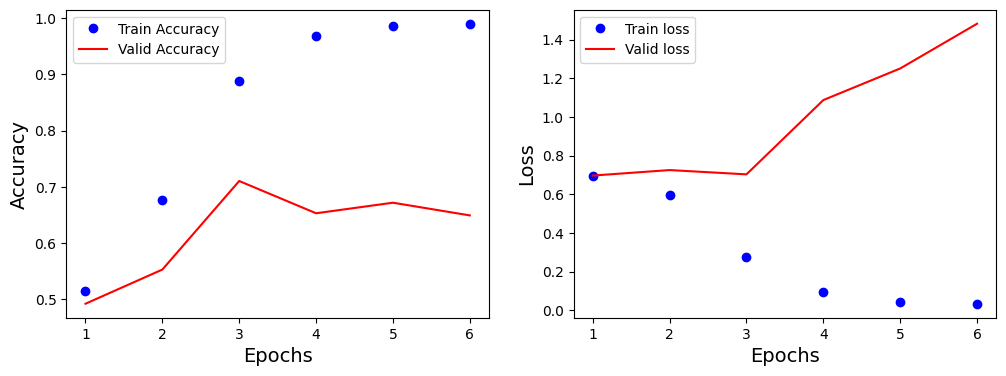

In [18]:
## Visualize the resutls
fia, ax = plt.subplots(1, 2, figsize=(12, 4))
n_epochs = len(history.history['loss'])  # real number of epochs in history, as we made early stopp
plt.sca(ax[0])
plt.plot(range(1, n_epochs+1), history.history['accuracy'], 'bo', label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history.history['val_accuracy'], 'r-', label='Valid Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy',  fontsize=14)
plt.legend()

plt.sca(ax[1])
plt.plot(range(1, n_epochs+1), history.history['loss'], 'bo', label='Train loss')
plt.plot(range(1, n_epochs+1), history.history['val_loss'], 'r-', label='Valid loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss',  fontsize=14)
plt.legend()
plt.show()

----

* `Bidirectional RNN`

In [19]:
model = tf.keras.models.Sequential([

    # RNN base
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=64)),

    # FC
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 64)           5669376   
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          16512     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               24704     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5718913 (21.82 MB)
Trainable params: 571

In [20]:
# Compile & fit
model.compile(loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            metrics=['accuracy'])

# earlys stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_padded, y_train,
                    validation_data=(X_test_padded, y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping])

Epoch 1/20
196/196 [==============================] - 58s 280ms/step - loss: 0.7176 - accuracy: 0.5016 - val_loss: 0.6929 - val_accuracy: 0.5097
Epoch 2/20
196/196 [==============================] - 50s 255ms/step - loss: 0.6930 - accuracy: 0.5097 - val_loss: 0.6932 - val_accuracy: 0.5094
Epoch 3/20
196/196 [==============================] - 52s 266ms/step - loss: 0.6918 - accuracy: 0.5273 - val_loss: 0.6939 - val_accuracy: 0.5092
Epoch 4/20
196/196 [==============================] - 52s 266ms/step - loss: 0.6857 - accuracy: 0.5474 - val_loss: 0.6941 - val_accuracy: 0.5172
Epoch 5/20
196/196 [==============================] - 50s 255ms/step - loss: 0.6721 - accuracy: 0.5699 - val_loss: 0.7165 - val_accuracy: 0.5188
Epoch 6/20
196/196 [==============================] - 55s 280ms/step - loss: 0.6564 - accuracy: 0.5916 - val_loss: 0.7444 - val_accuracy: 0.5270


In [21]:
# evaluate on test
test_loss, test_acc = model.evaluate(X_test_padded, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

782/782 [==============================] - 18s 24ms/step - loss: 0.7444 - accuracy: 0.5270
Test Loss: 0.7443870902061462
Test Accuracy: 0.5270000100135803


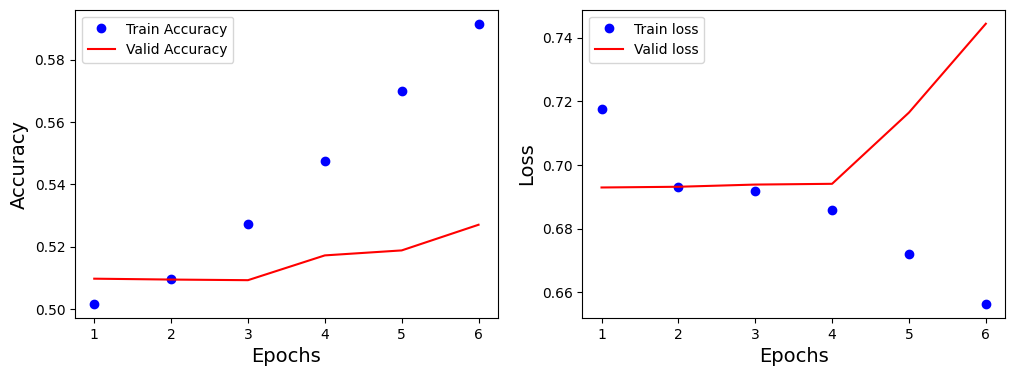

In [22]:
## Visualize the resutls
fia, ax = plt.subplots(1, 2, figsize=(12, 4))
n_epochs = len(history.history['loss'])  # real number of epochs in history, as we made early stopp
plt.sca(ax[0])
plt.plot(range(1, n_epochs+1), history.history['accuracy'], 'bo', label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history.history['val_accuracy'], 'r-', label='Valid Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy',  fontsize=14)
plt.legend()

plt.sca(ax[1])
plt.plot(range(1, n_epochs+1), history.history['loss'], 'bo', label='Train loss')
plt.plot(range(1, n_epochs+1), history.history['val_loss'], 'r-', label='Valid loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss',  fontsize=14)
plt.legend()
plt.show()

---

* `GRU`

In [23]:
model = tf.keras.models.Sequential([

    # RNN base
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=64, return_sequences=True)),
    tf.keras.layers.GRU(units=64, return_sequences=True),
    tf.keras.layers.GRU(units=32),

    # FC
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 64)           5669376   
                                                                 
 bidirectional_2 (Bidirecti  (None, 100, 128)          16512     
 onal)                                                           
                                                                 
 gru (GRU)                   (None, 100, 64)           37248     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                      

In [24]:
# Compile & fit
model.compile(loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            metrics=['accuracy'])

# earlys stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_padded, y_train,
                    validation_data=(X_test_padded, y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping])

Epoch 1/20
196/196 [==============================] - 97s 470ms/step - loss: 0.6983 - accuracy: 0.5033 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/20
196/196 [==============================] - 89s 454ms/step - loss: 0.6931 - accuracy: 0.5109 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 3/20
196/196 [==============================] - 103s 527ms/step - loss: 0.6901 - accuracy: 0.5386 - val_loss: 0.6920 - val_accuracy: 0.5215
Epoch 4/20
196/196 [==============================] - 107s 546ms/step - loss: 0.6805 - accuracy: 0.5757 - val_loss: 0.6908 - val_accuracy: 0.5316
Epoch 5/20
196/196 [==============================] - 96s 488ms/step - loss: 0.6485 - accuracy: 0.6273 - val_loss: 0.6163 - val_accuracy: 0.6635
Epoch 6/20
196/196 [==============================] - 92s 470ms/step - loss: 0.5294 - accuracy: 0.7417 - val_loss: 0.5586 - val_accuracy: 0.7005
Epoch 7/20
196/196 [==============================] - 92s 471ms/step - loss: 0.5104 - accuracy: 0.7556 - val_loss: 0.5363 - val_

In [25]:
# evaluate on test
test_loss, test_acc = model.evaluate(X_test_padded, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

782/782 [==============================] - 28s 36ms/step - loss: 0.5161 - accuracy: 0.7628
Test Loss: 0.5160730481147766
Test Accuracy: 0.7628399729728699


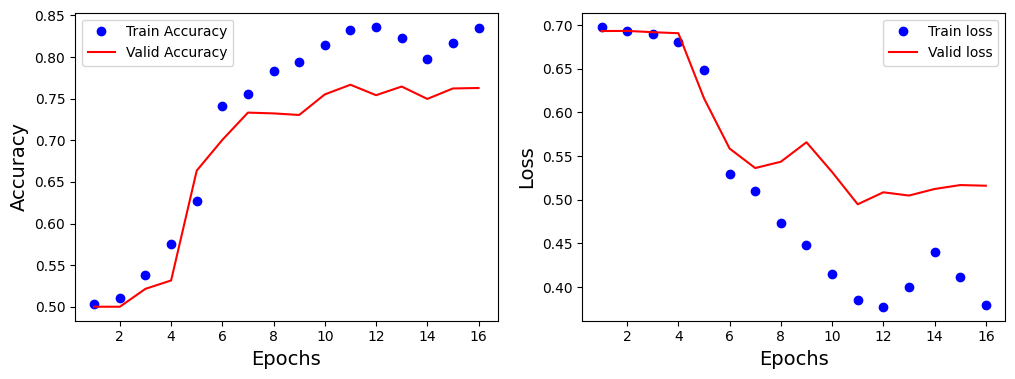

In [26]:
## Visualize the resutls
fia, ax = plt.subplots(1, 2, figsize=(12, 4))
n_epochs = len(history.history['loss'])  # real number of epochs in history, as we made early stopp
plt.sca(ax[0])
plt.plot(range(1, n_epochs+1), history.history['accuracy'], 'bo', label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history.history['val_accuracy'], 'r-', label='Valid Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy',  fontsize=14)
plt.legend()

plt.sca(ax[1])
plt.plot(range(1, n_epochs+1), history.history['loss'], 'bo', label='Train loss')
plt.plot(range(1, n_epochs+1), history.history['val_loss'], 'r-', label='Valid loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss',  fontsize=14)
plt.legend()
plt.show()

---
* `LSTM`

In [27]:
model = tf.keras.models.Sequential([

    # RNN base
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),
    tf.keras.layers.LSTM(units=64, return_sequences=True),
    tf.keras.layers.GRU(units=32),

    # FC
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 64)           5669376   
                                                                 
 bidirectional_3 (Bidirecti  (None, 100, 128)          66048     
 onal)                                                           
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           49408     
                                                                 
 gru_2 (GRU)                 (None, 32)                9408      
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                      

In [28]:
# Compile & fit
model.compile(loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            metrics=['accuracy'])

# earlys stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_padded, y_train,
                    validation_data=(X_test_padded, y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping])

Epoch 1/20
196/196 [==============================] - 163s 797ms/step - loss: 0.6264 - accuracy: 0.6318 - val_loss: 0.4620 - val_accuracy: 0.7889
Epoch 2/20
196/196 [==============================] - 152s 777ms/step - loss: 0.3545 - accuracy: 0.8487 - val_loss: 0.3968 - val_accuracy: 0.8211
Epoch 3/20
196/196 [==============================] - 148s 759ms/step - loss: 0.2416 - accuracy: 0.9058 - val_loss: 0.4449 - val_accuracy: 0.8004
Epoch 4/20
196/196 [==============================] - 155s 795ms/step - loss: 0.1702 - accuracy: 0.9383 - val_loss: 0.4970 - val_accuracy: 0.8065
Epoch 5/20
196/196 [==============================] - 155s 791ms/step - loss: 0.1171 - accuracy: 0.9597 - val_loss: 0.6403 - val_accuracy: 0.7826
Epoch 6/20
196/196 [==============================] - 152s 779ms/step - loss: 0.0861 - accuracy: 0.9716 - val_loss: 0.6104 - val_accuracy: 0.8014
Epoch 7/20
196/196 [==============================] - 159s 814ms/step - loss: 0.0590 - accuracy: 0.9813 - val_loss: 0.7996 -

In [29]:
# evaluate on test
test_loss, test_acc = model.evaluate(X_test_padded, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

782/782 [==============================] - 40s 51ms/step - loss: 0.7996 - accuracy: 0.7899
Test Loss: 0.7995781898498535
Test Accuracy: 0.7899199724197388


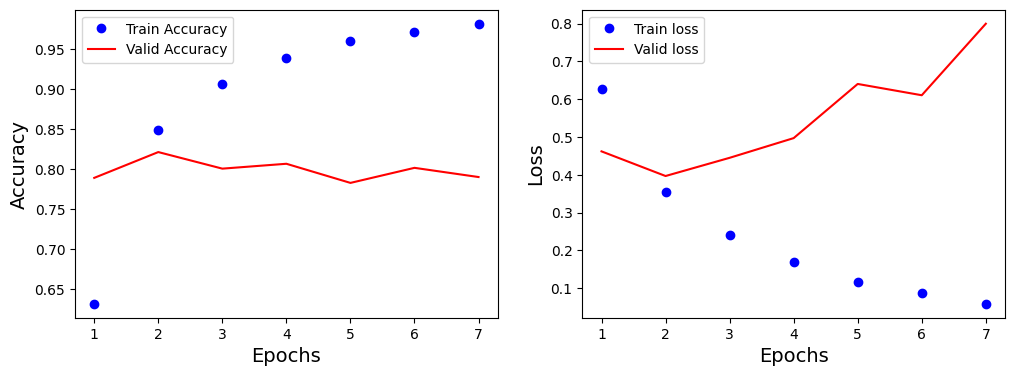

In [30]:
## Visualize the resutls
fia, ax = plt.subplots(1, 2, figsize=(12, 4))
n_epochs = len(history.history['loss'])  # real number of epochs in history, as we made early stopp
plt.sca(ax[0])
plt.plot(range(1, n_epochs+1), history.history['accuracy'], 'bo', label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history.history['val_accuracy'], 'r-', label='Valid Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy',  fontsize=14)
plt.legend()

plt.sca(ax[1])
plt.plot(range(1, n_epochs+1), history.history['loss'], 'bo', label='Train loss')
plt.plot(range(1, n_epochs+1), history.history['val_loss'], 'r-', label='Valid loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss',  fontsize=14)
plt.legend()
plt.show()

* `Inference`

In [31]:
model.save('model.h5')
joblib.dump(word2idx, 'artifacts/word2idx.joblib')
joblib.dump(idx2word, 'artifacts/idx2word.joblib')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [59]:
text = "? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was shared with us all"

text_encoded = [word2idx.get(word, 0) for word in text.split()]

text_padded = tf.keras.preprocessing.sequence.pad_sequences([text_encoded], 
                                                            maxlen=100, 
                                                            padding='post', 
                                                            truncating='post', 
                                                            value=0)

model_lstm = tf.keras.models.load_model('../artifacts/model.h5')
['positive' if model_lstm.predict(text_padded)[0][0] >= 0.5 else 'Negative'][0]

1/1 [==============================] - 1s 1s/step


'Negative'